In [207]:
from jax import numpy as jnp
import numpy as np
from gaussian_toolbox import pdf,conditional
import matplotlib.pyplot as plt
import jax


Linear control modelling with noisy observation Model
----

Here we attempt to model the Linear control on a circle by adding the next level of complexity, i.e making hte observation model noisy. This makes the problem non-trivial compared to the example with no noise. 

At first we try to write functions to compute the filter density to be used in the expression of the free energy.

State model and observation model for this exampe 1, no action AND 1 dimesional!
----

first we attempt to model the filter density estimation in a model with no action!!!

**s_t+1 = s_t + b + state_noise**

**o_t = s_t + obs_noise**

for this we define a new class named custom_model

In [208]:
class custom_model:
    '''defining a custom linear model of the form : y_t=x_t+b+noise
    This is a special case of the linear control state space model with A=I and action u_t=0 for all t'''
    def __init__(self,b,noise_scale):
        self.b=b
        self.noise_scale=noise_scale
        self.Dz=len(b)
        self.Qz = noise_scale**2 * jnp.eye(self.Dz)
        self.M=jnp.eye(self.Dz)
        self.density = conditional.ConditionalGaussianPDF(M=jnp.array([jnp.eye(self.Dz)]), b=jnp.array([self.b]), Sigma=jnp.array([self.Qz]))
    def compute_y_t(self,x_t):
        return np.matmul(self.M,x_t)+self.b+np.random.normal(0,self.noise_scale)
    
            

In [209]:
np.shape(jnp.array([jnp.array([np.array((2,))])]))

(1, 1, 1)

We now create the state and observation models as instances of this class

In [210]:
#defining the model for the 1D example with no action
Dx=1
Dz=1
#defining b for state model, with shape (Dz,)
b=np.array((2,))
#defining noises for botht he models
state_noise=0.3
obs_noise=1.2

#constructing the models
sm=custom_model(b,state_noise)
om=custom_model(np.array((0,)),obs_noise)



Defining the prior distribution for the states and sample s0 from it

In [211]:
#defining the prior state distribution


prior_noise=0.1
mu=np.array([np.array((1,))])

Sigma=jnp.array([prior_noise*jnp.eye(Dz)])
prior=pdf.GaussianPDF(Sigma=Sigma,mu=mu)
key = jax.random.PRNGKey(86)
s0=prior.sample(num_samples=1,key=key)[0][0]#to ensure that s0 has shape (1,)




Simulating the state dynamics for T steps

In [212]:
T=50
state_timeseries=[]
state_timeseries.append(s0)
for i in range(T):
    s_t=state_timeseries[-1]
    s_t_plus_one=sm.compute_y_t(s_t)
    state_timeseries.append(s_t_plus_one)
print(state_timeseries)

[Array([1.1622026], dtype=float32), array([3.6161892]), array([5.66461315]), array([7.59628325]), array([9.08118175]), array([11.86030411]), array([13.7333144]), array([15.63398284]), array([17.73267823]), array([19.87254163]), array([21.50193083]), array([23.64707388]), array([25.67181409]), array([27.51283503]), array([29.20895626]), array([30.97845938]), array([33.1733217]), array([35.00596175]), array([36.6959982]), array([39.07775474]), array([41.32738093]), array([43.55052457]), array([45.49620021]), array([47.68565466]), array([49.20110667]), array([51.05244201]), array([53.24112045]), array([55.51126934]), array([57.48146171]), array([59.499403]), array([61.30424465]), array([63.15977005]), array([65.04467818]), array([66.60492777]), array([68.74700909]), array([70.61190937]), array([72.9465688]), array([74.87529322]), array([77.08913036]), array([79.21113702]), array([81.32430301]), array([83.14982767]), array([85.19495461]), array([87.67141294]), array([90.24161348]), array([

Now generating observations for these latent states using noisy observation model!!

In [213]:
obs_timeseries=[]
#number of data points is always T+1
for i in range(T+1):
    o_t=om.compute_y_t(state_timeseries[i])
    obs_timeseries.append(o_t)
print(obs_timeseries)
    

[array([0.60871256]), array([4.92729509]), array([4.88779837]), array([8.65430135]), array([10.13915864]), array([13.11968019]), array([14.23688447]), array([14.41472178]), array([19.29829965]), array([20.34374553]), array([21.59262294]), array([26.40425837]), array([25.35492721]), array([27.46021682]), array([30.85933414]), array([29.02573492]), array([34.06088336]), array([35.09529261]), array([36.45691811]), array([37.05795921]), array([43.4221975]), array([43.17493367]), array([44.31033065]), array([46.25514059]), array([49.22258188]), array([49.13671145]), array([53.80455029]), array([54.21284641]), array([58.67734264]), array([57.79975532]), array([62.08548884]), array([63.88015242]), array([65.46883695]), array([66.33136792]), array([69.18036825]), array([70.25149193]), array([72.92446605]), array([72.99750917]), array([77.04681062]), array([76.92054842]), array([83.39519956]), array([83.35167927]), array([85.98764478]), array([89.61281679]), array([89.33234242]), array([93.5056

Plotting the states and observation


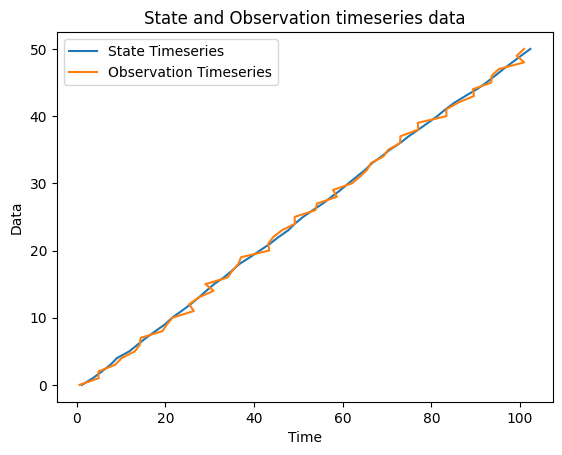

In [214]:
time=np.arange(T+1)
plt.plot(state_timeseries,time,label='State Timeseries')
plt.plot(obs_timeseries,time,label='Observation Timeseries')

plt.xlabel("Time")
plt.ylabel("Data")
plt.title("State and Observation timeseries data")
plt.legend(loc="upper left")
plt.show()

Now since this is done, lets estimate the states just from the observation time series and compare with the actual states. For this we use observation density and prediction density.


In [215]:
state_density=sm.density
obs_density=om.density
type(state_density)

gaussian_toolbox.conditional.ConditionalGaussianPDF

Now we are actually estimating filter densities and prediction densitites of each step and adding to the prediction_list and filter_list. The first elemet of prediction list is the prior.

In [216]:
prediction=prior
prediction_list=[]
prediction_list.append(prediction)
filter_list=[]
for i in range(T+1):
    p_s_given_o=obs_density.affine_conditional_transformation(prediction)

    filter=p_s_given_o.condition_on_x(np.array([obs_timeseries[i],]))
    filter_list.append(filter)
    
    prediction=state_density.affine_marginal_transformation(filter)
    prediction_list.append(prediction)
    
    


Now we use the filter densities at each step to generate estimations of the states


In [217]:
state_estimated=[]

for i in range(T+1):
    filter=filter_list[i]
    key = jax.random.PRNGKey(86)

    s_t=filter.sample(num_samples=1,key=key)[0][0]#to ensure that the samples have shape(1,)
    state_estimated.append(s_t)
print(state_estimated)

[Array([1.1314394], dtype=float32), Array([3.402245], dtype=float32), Array([5.3872385], dtype=float32), Array([7.6697793], dtype=float32), Array([9.821372], dtype=float32), Array([12.146815], dtype=float32), Array([14.228471], dtype=float32), Array([15.903629], dtype=float32), Array([18.269054], dtype=float32), Array([20.348911], dtype=float32), Array([22.246819], dtype=float32), Array([24.784664], dtype=float32), Array([26.533703], dtype=float32), Array([28.36094], dtype=float32), Array([30.53462], dtype=float32), Array([31.824474], dtype=float32), Array([33.94044], dtype=float32), Array([35.817772], dtype=float32), Array([37.58129], dtype=float32), Array([39.088264], dtype=float32), Array([41.66714], dtype=float32), Array([43.622337], dtype=float32), Array([45.396603], dtype=float32), Array([47.208504], dtype=float32), Array([49.275433], dtype=float32), Array([50.86724], dtype=float32), Array([53.137917], dtype=float32), Array([54.997578], dtype=float32), Array([57.43211], dtype=flo

Now plotting the observation timeseries, state time series and estimated state time series together to compare

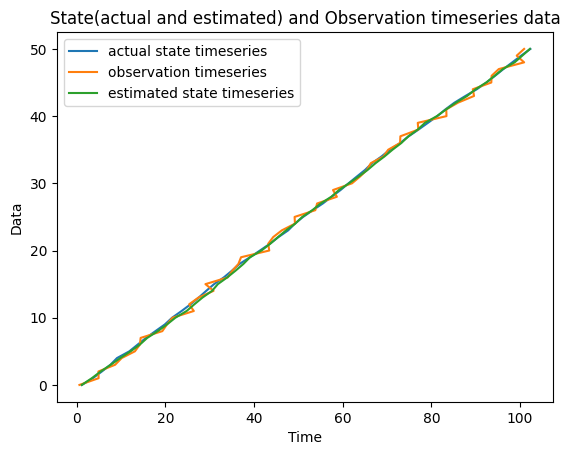

In [218]:

time=np.arange(T+1)
plt.plot(state_timeseries,time,label='actual state timeseries')
plt.plot(obs_timeseries,time,label='observation timeseries')
plt.plot(state_estimated,time,label='estimated state timeseries')
plt.xlabel("Time")
plt.ylabel("Data")
plt.title("State(actual and estimated) and Observation timeseries data")
plt.legend(loc="upper left")
plt.show()

Decent agreement, but why always an **overestimate**????????

State model and observation model for this exampe 2, no action AND 2 dimesional!
----

In [219]:
#defining the model for the 1D example with no action
Dx=2
Dz=2
#defining b for state model, with shape (Dz,)
b=np.array([1,2])
#defining noises for botht he models
state_noise=0.3
obs_noise=1.2

#constructing the models
sm=custom_model(b,state_noise)
om=custom_model(np.array([0,0]),obs_noise)



In [220]:
#defining the prior state distribution


prior_noise=0.1
mu=np.array([np.array([1,5])])

Sigma=jnp.array([prior_noise*jnp.eye(Dz)])
prior=pdf.GaussianPDF(Sigma=Sigma,mu=mu)
key = jax.random.PRNGKey(86)
s0=prior.sample(num_samples=1,key=key)[0][0]#to ensure that s0 has shape (2,)




In [221]:
T=50
state_timeseries=[]
state_timeseries.append(s0)
for i in range(T):
    s_t=state_timeseries[-1]
    s_t_plus_one=sm.compute_y_t(s_t)
    state_timeseries.append(s_t_plus_one)
print(state_timeseries)

[Array([0.6750767, 4.8177752], dtype=float32), array([1.52817637, 6.6708749 ]), array([2.63637639, 8.77907492]), array([ 3.66480603, 10.80750455]), array([ 4.48965467, 12.63235319]), array([ 5.83692707, 14.97962559]), array([ 6.85481262, 16.99751115]), array([ 7.91783862, 19.06053714]), array([ 9.03032533, 21.17302386]), array([10.28739376, 23.43009229]), array([10.95988307, 25.1025816 ]), array([11.66935582, 26.81205434]), array([12.47029778, 28.6129963 ]), array([13.46731033, 30.61000886]), array([14.42459281, 32.56729134]), array([15.6886785 , 34.83137702]), array([16.48229988, 36.62499841]), array([17.37311525, 38.51581378]), array([18.25626909, 40.39896761]), array([19.55282175, 42.69552027]), array([20.72986331, 44.87256184]), array([21.42150506, 46.56420359]), array([22.65666479, 48.79936331]), array([23.28338067, 50.4260792 ]), array([24.42869107, 52.5713896 ]), array([24.78669505, 53.92939357]), array([25.64311818, 55.78581671]), array([26.82083014, 57.96352867]), array([28.39

In [222]:
obs_timeseries=[]
#number of data points is always T+1
for i in range(T+1):
    o_t=om.compute_y_t(state_timeseries[i])
    obs_timeseries.append(o_t)
print(obs_timeseries)
    

[array([-1.16403544,  2.97866308]), array([2.69322638, 7.8359249 ]), array([2.63377951, 8.77647804]), array([ 4.03045415, 11.17315267]), array([ 4.15236007, 12.29505859]), array([ 6.14692557, 15.2896241 ]), array([ 7.39492543, 17.53762396]), array([ 6.85235618, 17.99505471]), array([ 9.29634274, 21.43904126]), array([ 9.18250018, 22.32519871]), array([ 9.59851798, 23.74121651]), array([10.26160211, 25.40430064]), array([12.09688261, 28.23958113]), array([11.97079389, 29.11349241]), array([13.87567146, 32.01836998]), array([15.5572537 , 34.69995222]), array([18.51156962, 38.65426815]), array([18.04715473, 39.18985326]), array([18.0851335 , 40.22783203]), array([20.27251545, 43.41521398]), array([19.96038857, 44.10308709]), array([19.67754836, 44.82024688]), array([23.1886253 , 49.33132383]), array([24.13528235, 51.27798088]), array([24.63544583, 52.77814435]), array([25.65128927, 54.7939878 ]), array([26.36786532, 56.51056384]), array([28.08393718, 59.2266357 ]), array([29.01308129, 61.

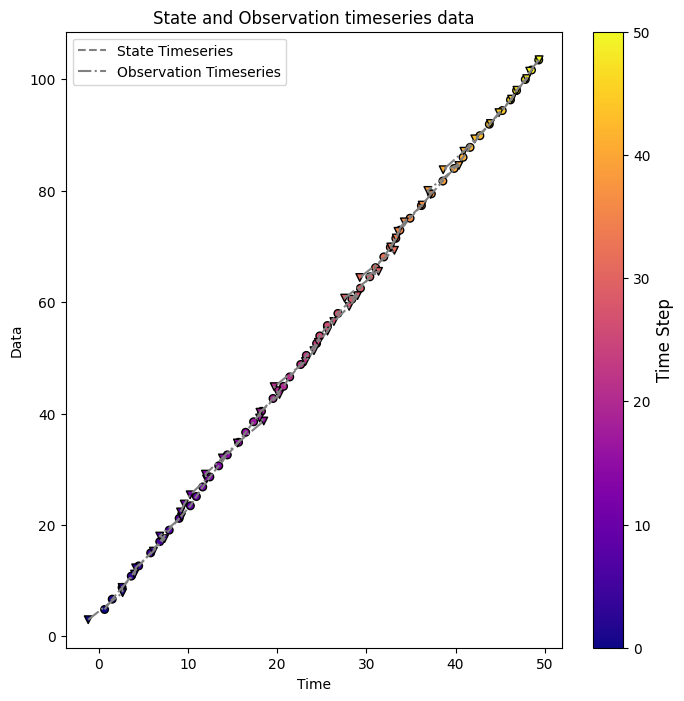

In [235]:
time=np.arange(T+1)
colors = plt.cm.plasma([t / max(time) for t in time])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

state_x=[state_timeseries[i][0] for i in range(T+1)]
state_y=[state_timeseries[i][1] for i in range(T+1)]

obs_x=[obs_timeseries[i][0] for i in range(T+1)]
obs_y=[obs_timeseries[i][1] for i in range(T+1)]


ax.plot(state_x,state_y,color='gray',linestyle='--',label='State Timeseries')
scatter = ax.scatter(state_x,state_y, c=time, cmap='plasma', edgecolor='k',marker='o', s=30)

ax.plot(obs_x,obs_y,color='gray',linestyle='-.',label='Observation Timeseries')
scatter = ax.scatter(obs_x,obs_y, c=time, cmap='plasma', edgecolor='k',marker='v', s=30)

# Add a colorbar to indicate time evolution
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Time Step', fontsize=12)

plt.xlabel("Time")
plt.ylabel("Data")
plt.title("State and Observation timeseries data")
plt.legend(loc="upper left")
plt.show()

In [224]:
state_density=sm.density
obs_density=om.density
type(state_density)

gaussian_toolbox.conditional.ConditionalGaussianPDF

In [225]:
prediction=prior
prediction_list=[]
prediction_list.append(prediction)
filter_list=[]
for i in range(T+1):
    p_s_given_o=obs_density.affine_conditional_transformation(prediction)

    filter=p_s_given_o.condition_on_x(np.array([obs_timeseries[i],]))
    filter_list.append(filter)
    
    prediction=state_density.affine_marginal_transformation(filter)
    prediction_list.append(prediction)
    
    


In [228]:
state_estimated=[]

for i in range(T+1):
    filter=filter_list[i]
    key = jax.random.PRNGKey(86)

    s_t=filter.sample(num_samples=1,key=key)[0][0]#to ensure that the samples have shape(1,)
    state_estimated.append(s_t)
print(state_estimated)

[Array([0.5452815, 4.692535 ], dtype=float32), Array([1.5391833, 6.7455854], dtype=float32), Array([2.4294896, 8.680758 ], dtype=float32), Array([ 3.4122102, 10.698223 ], dtype=float32), Array([ 4.239038, 12.551733], dtype=float32), Array([ 5.2984285, 14.63141  ], dtype=float32), Array([ 6.402542, 16.75086 ], dtype=float32), Array([ 7.158342, 18.518232], dtype=float32), Array([ 8.277778, 20.646408], dtype=float32), Array([ 9.129668, 22.504923], dtype=float32), Array([ 9.885738, 24.26603 ], dtype=float32), Array([10.620934, 26.00507 ], dtype=float32), Array([11.597987, 27.985071], dtype=float32), Array([12.332021, 29.721365], dtype=float32), Array([13.324095, 31.715178], dtype=float32), Array([14.468282, 33.860714], dtype=float32), Array([16.011868, 36.40534 ], dtype=float32), Array([17.112476, 38.506756], dtype=float32), Array([17.978617, 40.37352 ], dtype=float32), Array([19.13632, 42.53171], dtype=float32), Array([19.969658, 44.365425], dtype=float32), Array([20.556671, 45.95273 ], d

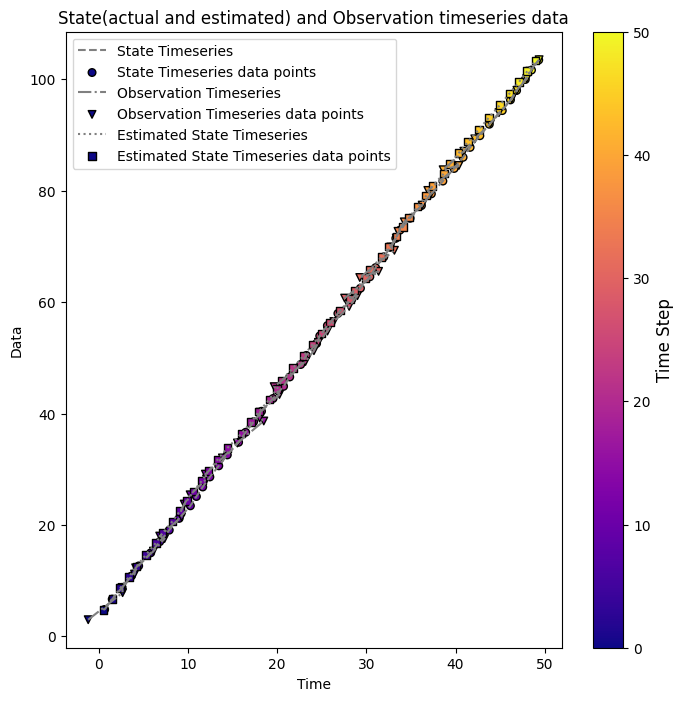

In [234]:
time=np.arange(T+1)
colors = plt.cm.plasma([t / max(time) for t in time])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

state_x=[state_timeseries[i][0] for i in range(T+1)]
state_y=[state_timeseries[i][1] for i in range(T+1)]

obs_x=[obs_timeseries[i][0] for i in range(T+1)]
obs_y=[obs_timeseries[i][1] for i in range(T+1)]

state_esti_x=[state_estimated[i][0] for i in range(T+1)]
state_esti_y=[state_estimated[i][1] for i in range(T+1)]



ax.plot(state_x,state_y,color='gray',linestyle='--',label='State Timeseries')
scatter = ax.scatter(state_x,state_y, c=time, cmap='plasma', edgecolor='k',marker='o', s=30,label='State Timeseries data points')

ax.plot(obs_x,obs_y,color='gray',linestyle='-.',label='Observation Timeseries')
scatter = ax.scatter(obs_x,obs_y, c=time, cmap='plasma', edgecolor='k',marker='v', s=30,label='Observation Timeseries data points')

ax.plot(state_esti_x,state_esti_y,color='gray',linestyle=':',label='Estimated State Timeseries')
scatter = ax.scatter(state_esti_x,state_esti_y, c=time, cmap='plasma', edgecolor='k',marker='s', s=30,label='Estimated State Timeseries data points')

# Add a colorbar to indicate time evolution
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Time Step', fontsize=12)

plt.xlabel("Time")
plt.ylabel("Data")
plt.title("State(actual and estimated) and Observation timeseries data")
plt.legend(loc="upper left")
plt.show()

Modelling an agent in 2d plane, with preferred state being the unit circle with noisy observation channel
---